In [1]:
# Code for project 1
# Jack Jiang
# CMDA 3634

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
import time
import timeit
from sklearn.linear_model import LinearRegression
%matplotlib notebook

Matplotlib created a temporary config/cache directory at /localscratch/133995/matplotlib-eu56jonz because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# CODING

In [2]:
# Task 1

# Evaluates the standing wave equation
# omega to the wave equation u_k on the
# computational grid.
#
# Parameters:
#     n = size of computational grid, nxn
#     t = current time in the simulation
#     m_x, m_y = number of nodes in standing wave
#
# Returns:
#     The computed wave equation on the computational grid.
def to_wave_equation(n, t, m_x, m_y):
    omega = np.pi * np.sqrt((m_x)**2 + (m_y)**2)
    matrix = []
    matrix = np.empty([n, n])
    d_xy = 1 / (n-1)
    
    for j in range(np.shape(matrix)[0]):
        for i in range(np.shape(matrix)[1]):
            y = j * d_xy;
            x = i * d_xy;
            matrix[j][i] = (np.sin(m_x * np.pi * x) * np.sin(m_y * np.pi * y) * 
            np.cos(omega * t))
    return matrix    # return 

# Do we need to replace the (x, y) coordinates with grid indices such
# that x = idx and y = jdy?

<IPython.core.display.Javascript object>


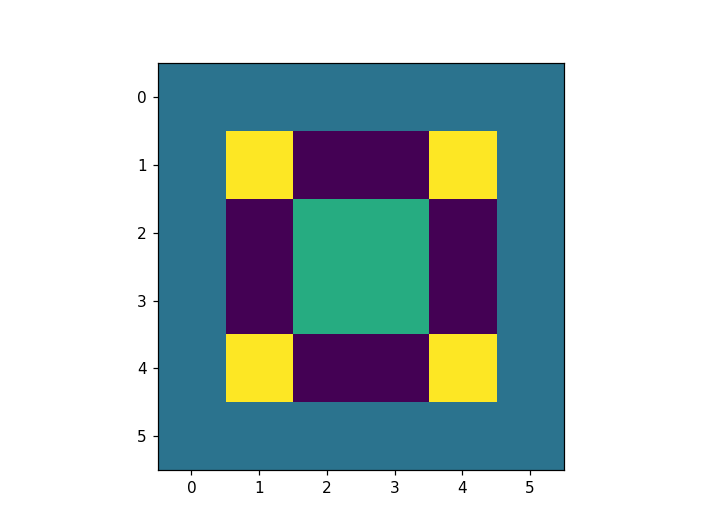

In [3]:
plt.imshow(to_wave_equation(6, 1, 3, 3))

# How do I check if I'm on right path?...Is there a way
# to check graphs are correct?

In [4]:
# Task 2

# Checks if a coordinate is a boundary point.
#
# Parameters:
#     array = an existing numpy array of size nxn
#     n = length/width of square grid nxn
#     x = x-coordinate of point
#     y = y-coordinate of point
#
# Returns:
#     True if coordinate is a boundary point, false otherwise.
def boundary_check(n, i, j):
    if (i == 0 or i == (n-1) or j == 0 or j == (n-1)):
        return True
    return False

# Computes one time step of the
# wave equation simulation, u_k+1.
#
# Parameters:
#     array = an existing numpy array of size nxn
#     t = current time in the simulation
#     m_x, m_y = number of nodes in standing wave
#
# Returns:
#     A computed time step of the wave equation simulation.
# need to pass uk current
def timestep(n, t, m_x, m_y, u_kprev, u_kcurr, dt):
    u_knext = u_kcurr
    d_xy = 1 / (n-1)
    
    for j in range(np.shape(u_knext)[0]):
        for i in range(np.shape(u_knext)[1]):
            if boundary_check(n, i, j):
                u_knext[j][i] = 0
            else:
                lap = ((-4 * u_kcurr[j][i] + u_kcurr[j-1][i] +  
                        u_kcurr[j][i-1] + u_kcurr[j+1][i] + 
                        u_kcurr[j][i+1]) / d_xy**2)
                u_knext[j][i] = (-(u_kprev[j][i]) + 2*u_kcurr[j][i] + 
                        (dt**2 * lap))
                
    return u_knext

# Does putting delta t as a param work? 
# My logic is it will be called in function 3 simulate as a param...

In [5]:
# Task 3

# Computes and returns n_t iterations of the simulation.
#
# Parameters:
#     T = final simulation time
#     n = grid size of the computational grid
#     m_x, m_y = number of stationary nodes
# Returns:
#     A list of simulated wave equation grids.
def simulate(T, n, m_x, m_y):
    alpha = 1.001    # to be varied
    dx = 1 / (n - 1)
    dt = (alpha * dx) / np.sqrt(2)

    
    U = [[] for i in range(4)]       # Animation fn takes in list as arg
    u_kprev = to_wave_equation(n, -dt, m_x, m_y)
    u_kcurr = to_wave_equation(n, 0, m_x, m_y)
    U.append(u_kprev)
    U.append(u_kcurr)
    """
    Logic of for loop:
    initialize a grid with 1st function, go into if block,
    store into u_kprev, increment time, close off if block with flag, 
    get timestep and store into u_knext, append it to list, increment time
        
    """
    n_t = 0
    t = 0
    while t <= T:
        t0 = time.time()
        u_knext = timestep(n, time, m_x, m_y, u_kprev, u_kcurr, dt)
        copyu = np.copy(u_knext)
        U[0].append(copyu) #make copy of uk next
        U[0].append(u_knext)
        copyucurr = np.copy(u_kcurr)
        u_kprev = copyucurr
        u_kcurr = copyu
        t1 = time.time()
        timestep_time = t1 - t0
        U[2].append(timestep_time)
        t += dt
        n_t += 1
    U[1].append(n_t)
    U[3].append(dt)
    return U

In [6]:
U = simulate(10, 10, 5, 4)
U[1]

[128]

In [7]:
# Task 4

# modify and make sure proper orientation, axis labels and ranges, and
# shows simulation time on each frame (not run time)...
# simulation time as in simulation function
def animate_wave_simulation_2D(U, dt):
    """
    Creates a 2D animation of a wave simulation.

    Automatically selects color-scale.  In the event of instability or
    a wild range of values, some components might not be easily seen.
    Consider tweaking this scale if you need to.

    Parameters
    ----------
    U: list-like
       A list of 2D wavefields to animate.

    Returns
    -------
    Matplotlib animation class instance.

    """

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cmin, cmax = U[0].min(), U[0].max()
   
    
    for u in U:
        cmin = min(cmin, u.min())
        cmax = max(cmax, u.max())
   

    cmin = max(-1, cmin)
    cmax = min(1, cmax)
   
    im = plt.imshow(U[0], clim=(cmin,cmax), cmap='gray')
 
      
    def animate(i):
        im.set_data(U[i])
        
        t = i * dt
        
        ax.set_title("Time = {}".format(t))   
        return (im,)

        
    
    ax.set_xlabel("x-dimension")
    ax.set_ylabel("y-dimension")
    ani = animation.FuncAnimation(fig, animate, interval=50,blit=False,repeat_delay=1000)

    return ani


def animate_wave_simulation_3D(U, dt):
    """
    Creates a 3D surface animation of a wave simulation.

    Automatically selects color-scale.  In the event of instability or
    a wild range of values, some components might not be easily seen.
    Consider tweaking this scale if you need to.

    Adapted from https://stackoverflow.com/a/45713451 under the 
    CC BY-SA 3.0 license.

    Parameters
    ----------
    U: list-like
       A list of 2D wavefields to animate.

    Returns
    -------
    Matplotlib animation class instance.

    """
    
    
    grid_y = np.linspace(0, 1, U[0].shape[0])
    grid_x = np.linspace(0, 1, U[0].shape[1])
    YY, XX = np.meshgrid(grid_y, grid_x)
    
    fig = plt.figure()
    #ax = p3.Axes3D(fig)
    ax = fig.add_subplot(111, projection='3d')
    
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    cmin, cmax = U[0].min(), U[0].max()
    for u in U:
        cmin = min(cmin, u.min())
        cmax = max(cmax, u.max())

    cmin = max(-1, cmin)
    cmax = min(1, cmax)

    surf = [ax.plot_surface(YY, XX, U[0], cmap="viridis", clim=(cmin, cmax))]
    ax.set_zlim(1.1*cmin, 1.1*cmax)
    
    y = 1
    
    def animate(i, U, surf):
        surf[0].remove()
        surf[0] = ax.plot_surface(YY, XX, U[i], cmap="viridis", 
                                  clim=(-1,1))    
        t = i*dt
        ax.set_title("Time = {}".format(t))  
    ani = animation.FuncAnimation(fig, animate, fargs=(U, surf), interval=50,repeat_delay=1000)

    return ani

<IPython.core.display.Javascript object>


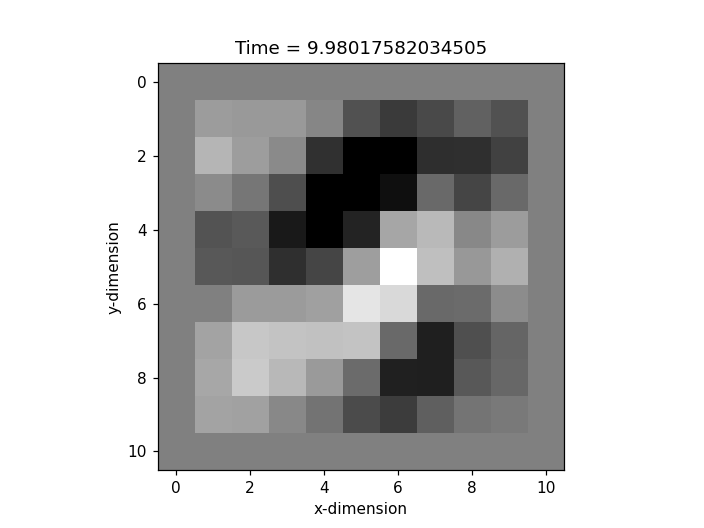

In [8]:
# Animation test
T = 5
n = 11
m_x = 2
m_y = 3
U = simulate(T, n, m_x, m_y)
# timing is how long simulation takes for each iteration...
# timing simulation function
animate_wave_simulation_2D(U[0], U[3][0])

<IPython.core.display.Javascript object>


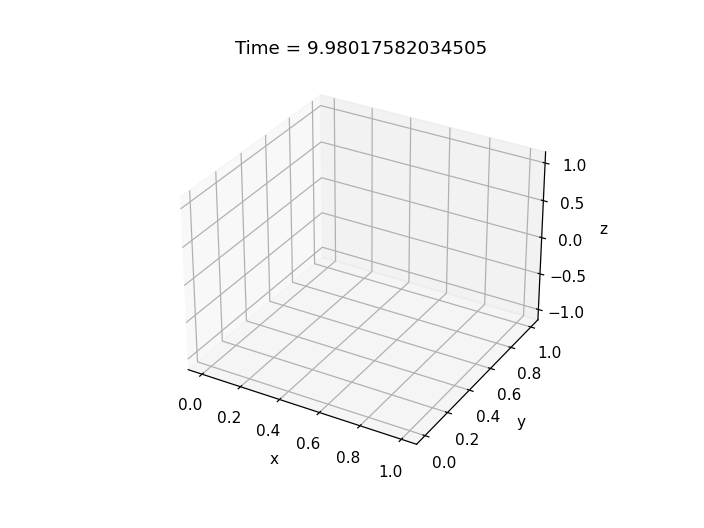

In [9]:
animate_wave_simulation_3D(U[0], U[3][0])

# ANALYSIS

In [ ]:
# Task 1
U = []
deltax = []
deltat = []
n_t = []
store_time = []
avg_run_time = []
n = [11, 26, 51, 101, 201, 301]
m_x = 12
m_y = 7
T = 5

for num in n:
    t0 = time.time()
    U = simulate(T, num, m_x, m_y)
    t1 = time.time()
    total_run_time = t1 - t0
    store_time.append(total_run_time)
    dx = 1 / (num - 1)
    dt = U[3][0]
    deltat.append(dt)
    deltax.append(dx)
    nt = round(T/dt)
    n_t.append(nt)
    
    avg_run_time.append(np.mean(U[2]))

In [ ]:
data = {'n' : n,
        'dx' : deltax,
        'dt' : deltat,
        'nt' : n_t,
        'Total Run-Time' : store_time,
       'Avg Time Per Time Step' : avg_run_time}
table = pd.DataFrame(data, columns = ['n', 'dx', 'dt', 'nt', 'Total Run-Time', 'Avg Time Per Time Step'])
table

In [ ]:
table

<IPython.core.display.Javascript object>


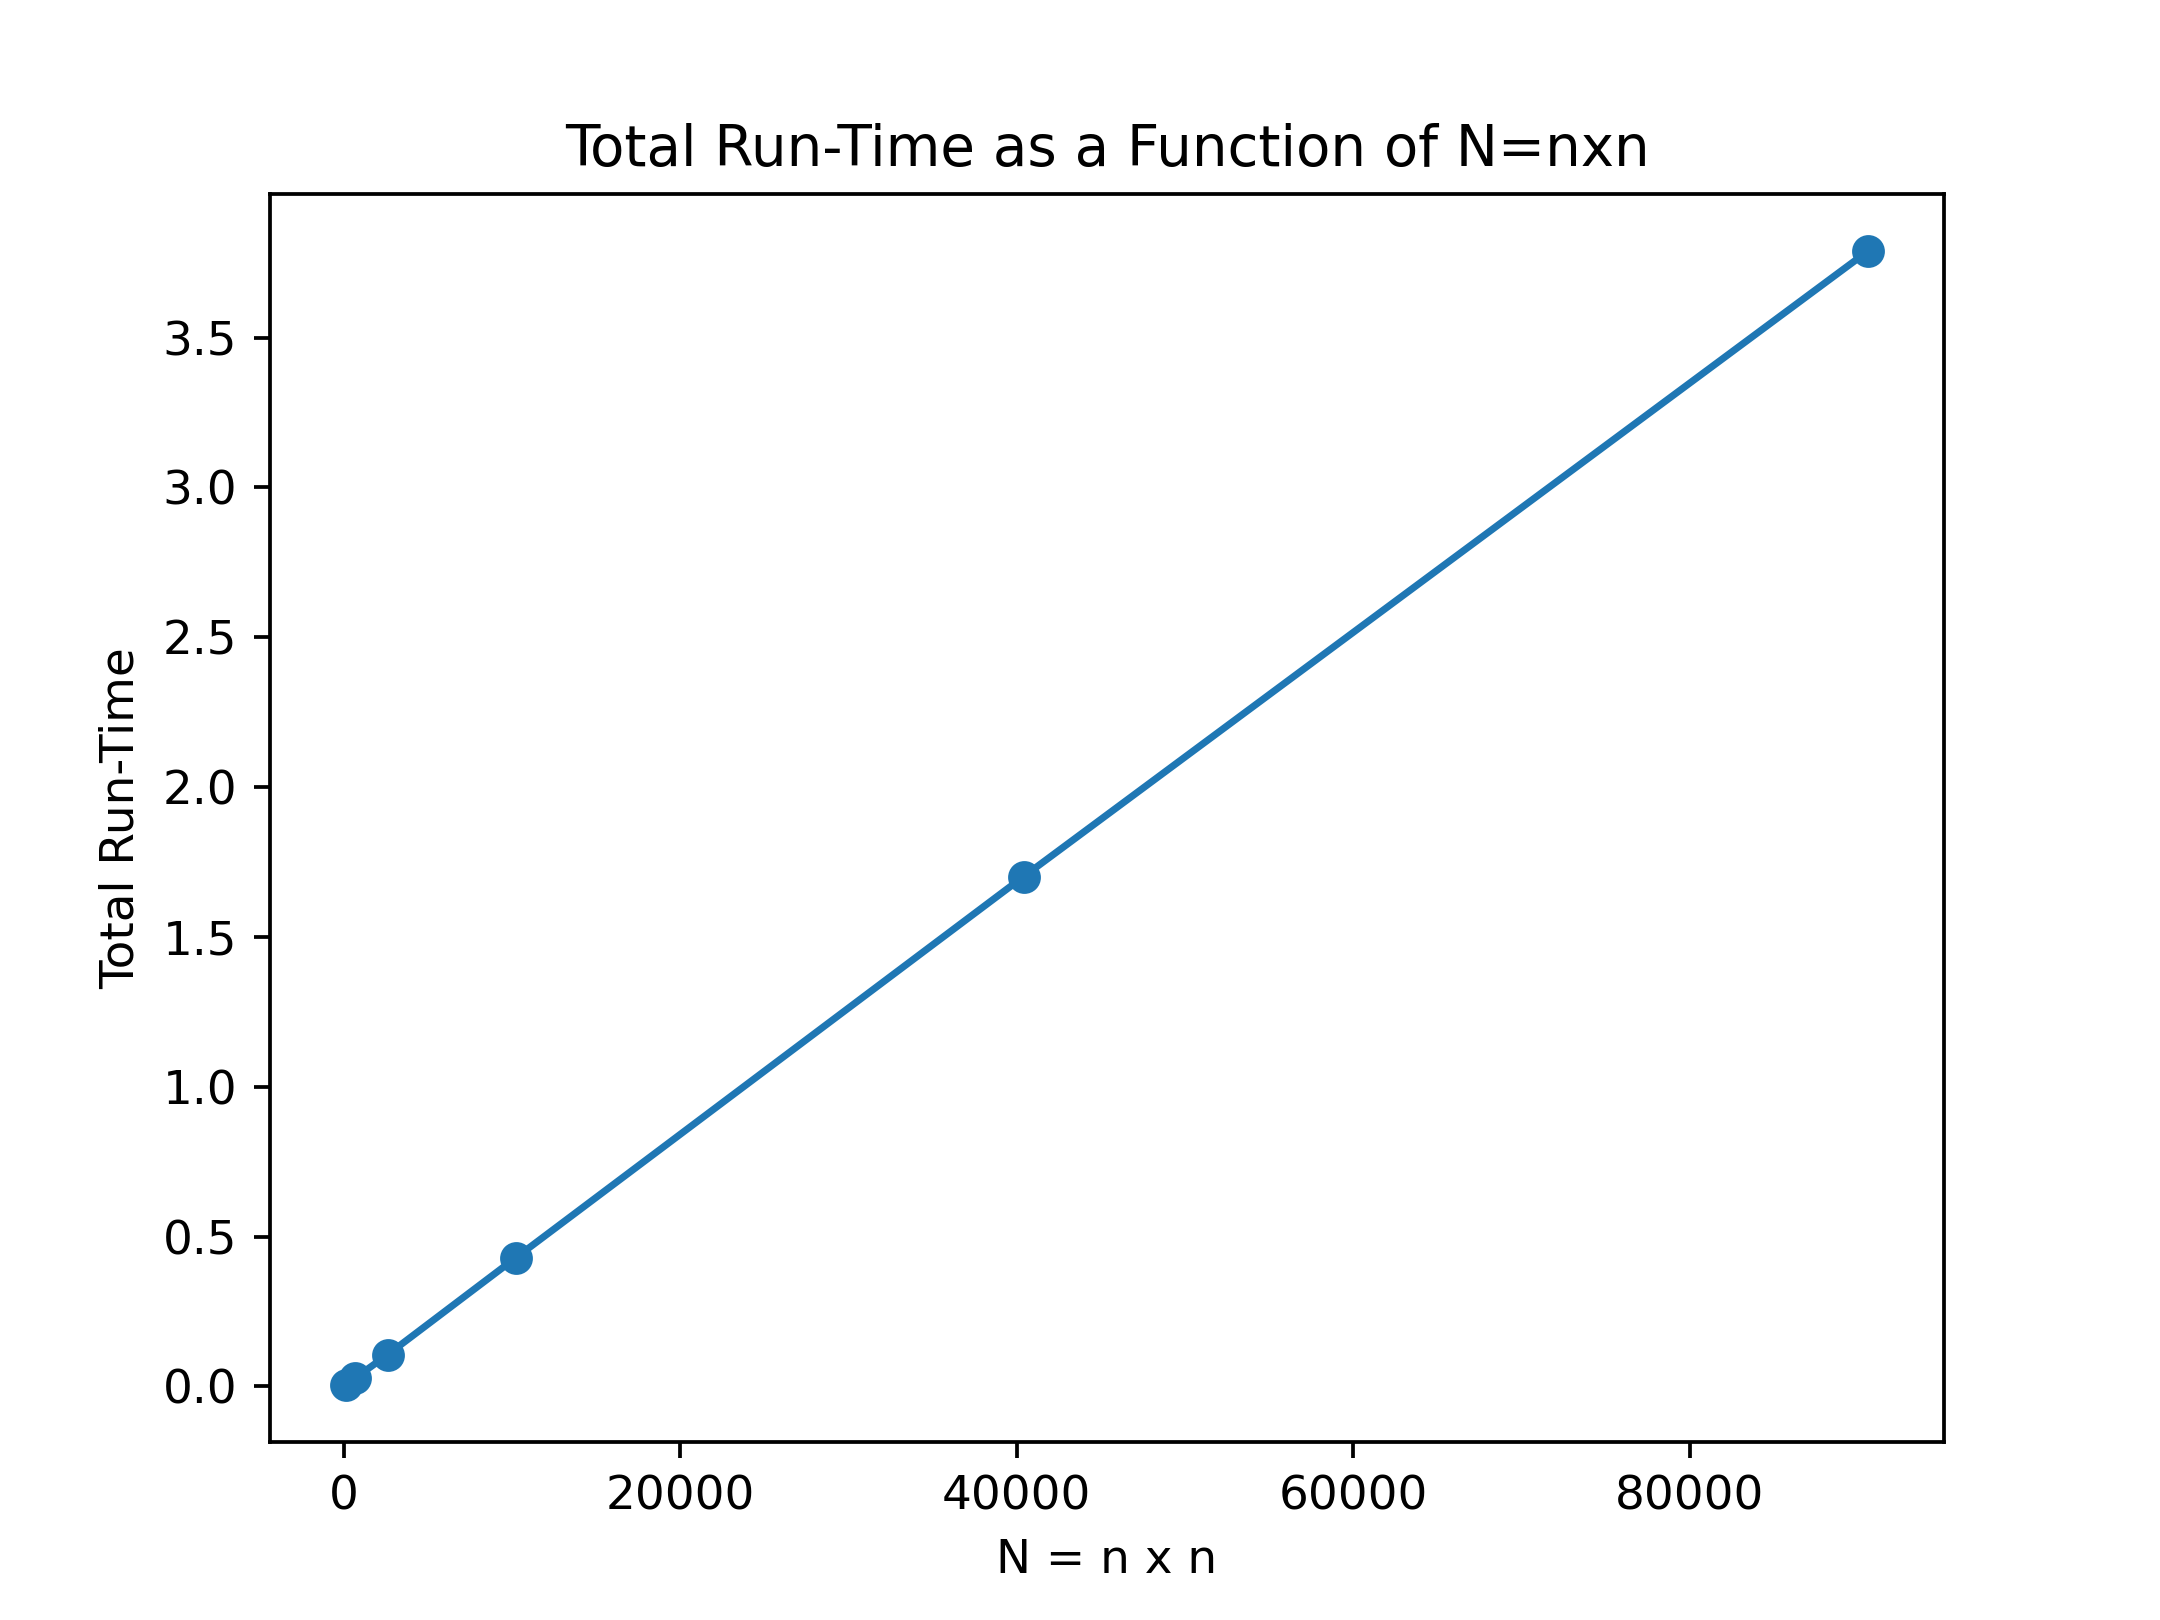

Text(0.5, 1.0, 'Total Run-Time as a Function of N=nxn')

In [168]:
fig1 = plt.figure()
new_n = [x**2 for x in n]
plt.plot(new_n, store_time, "-o")
plt.xlabel("N = n x n")
plt.ylabel("Total Run-Time")
plt.title("Total Run-Time as a Function of N=nxn")

<IPython.core.display.Javascript object>


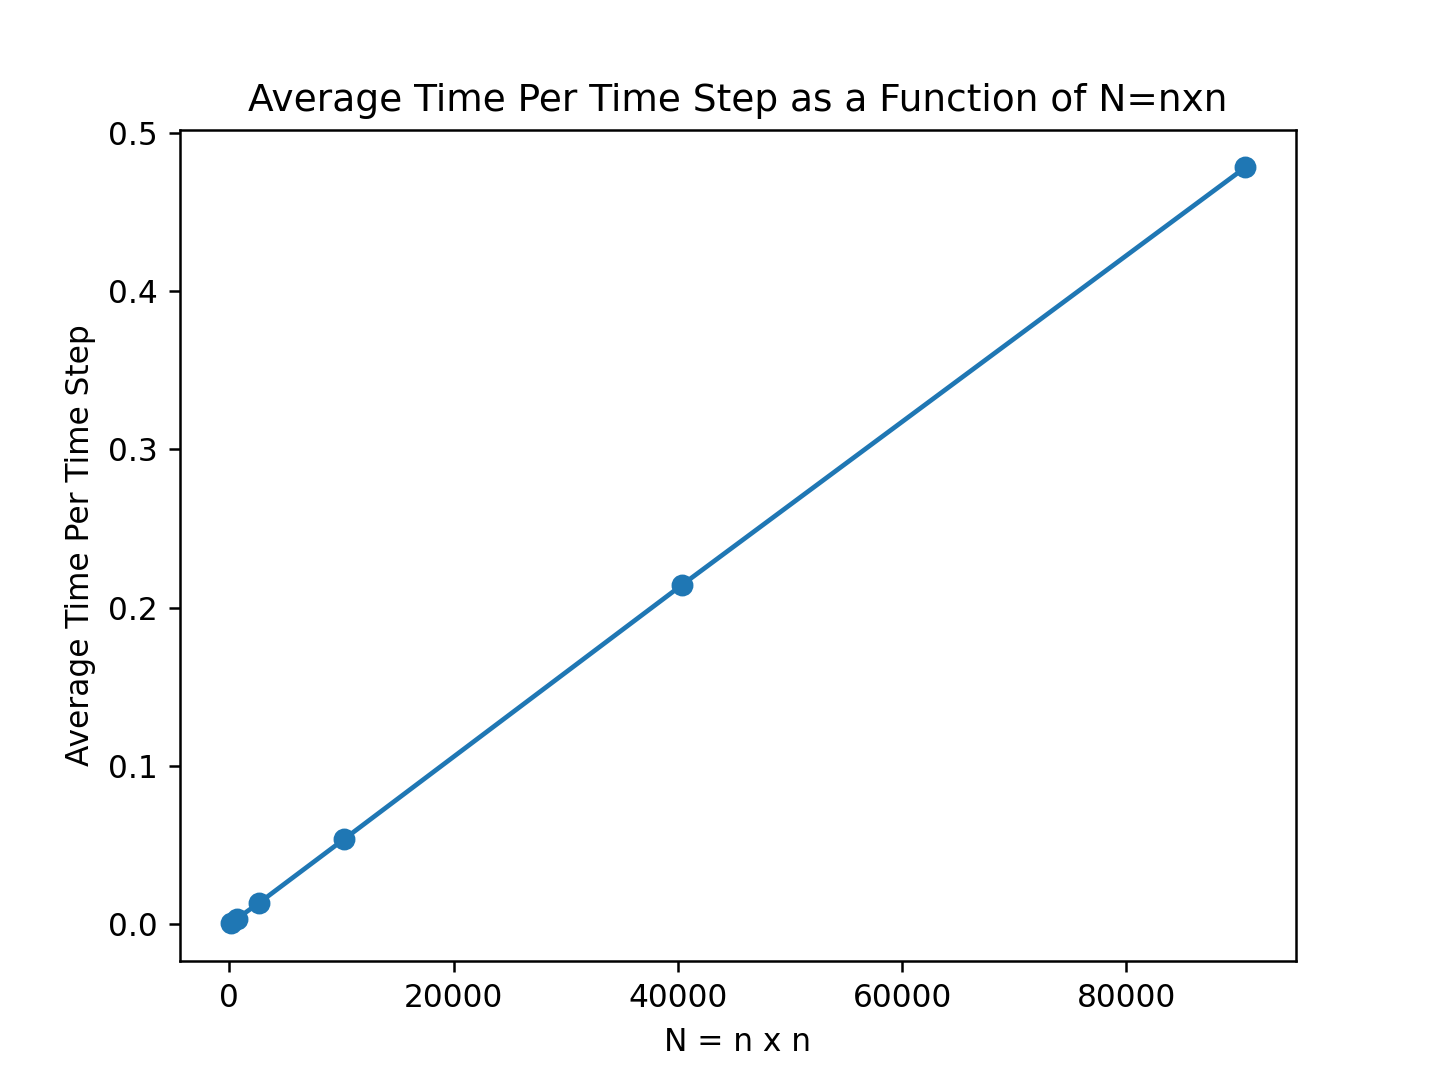

Text(0.5, 1.0, 'Average Time Per Time Step as a Function of N=nxn')

In [176]:
fig2 = plt.figure()
plt.plot(N, avg_run_time, "-o")
plt.xlabel("N = n x n")
plt.ylabel("Average Time Per Time Step")
plt.title("Average Time Per Time Step as a Function of N=nxn")

In [ ]:
# Task 2
fig3 = plt.figure()
x = n
y = n_t
plt.scatter(x, y)
model = np.polyfit(n, n_t, 1)
a = model[0]
b = model[1]
predict = np.poly1d(model)
x_lin_reg = range(302)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg)
predict(100000)


In [ ]:
x

In [ ]:
# Task 3
T = 5
n = 201
m_x = 12
m_y = 9
U = simulate(T, n, m_x, m_y)
animate_wave_simulation_2D(U[0], U[3][0])

<IPython.core.display.Javascript object>


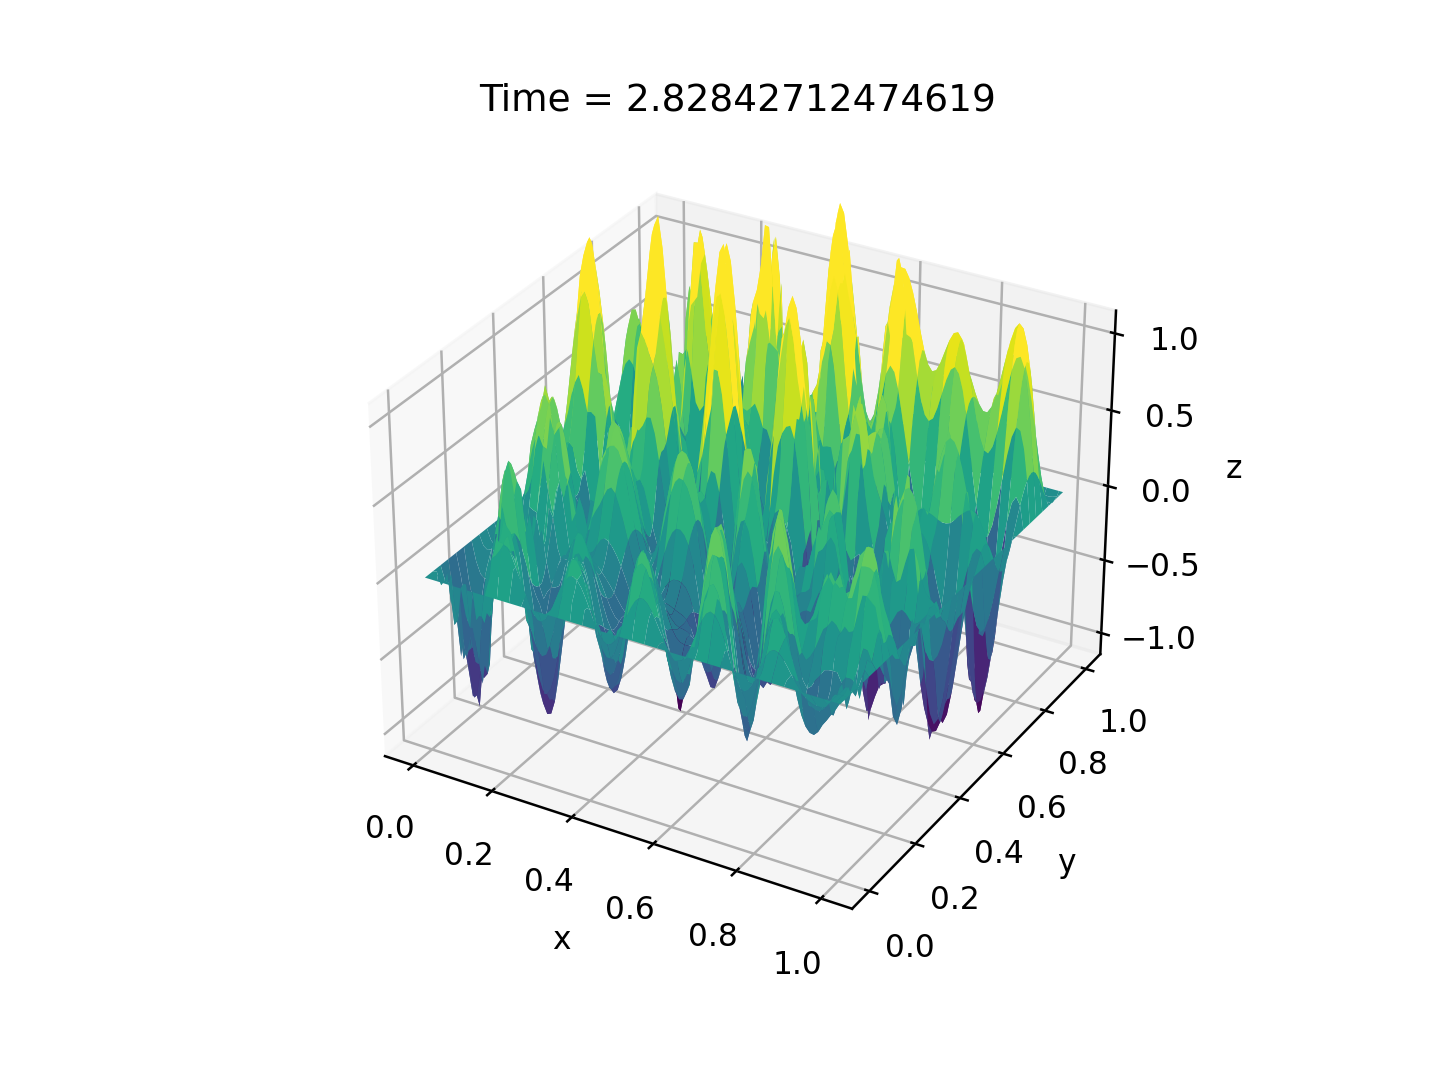

In [149]:
animate_wave_simulation_3D(U[0], U[3][0])

In [12]:
# Task 4
T = 5
n = 101
m_x = 3
m_y = 2
U = simulate(T, n, m_x, m_y)


<IPython.core.display.Javascript object>


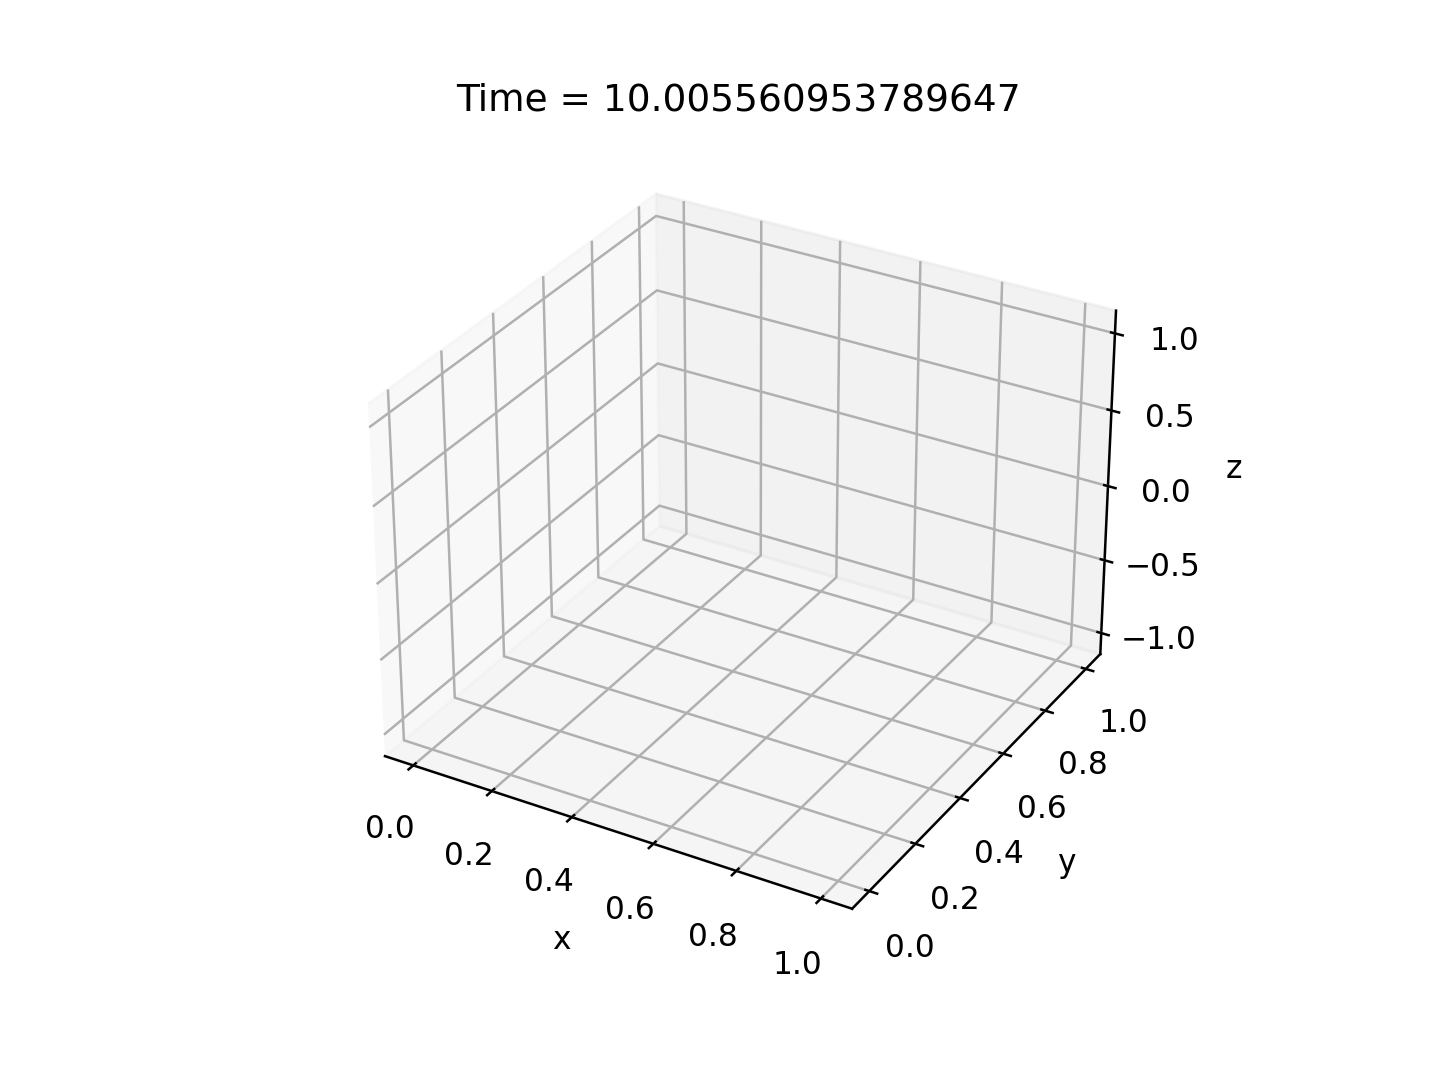

In [10]:
# alpha = 1.00
animate_wave_simulation_3D(U[0], U[3][0])

<IPython.core.display.Javascript object>


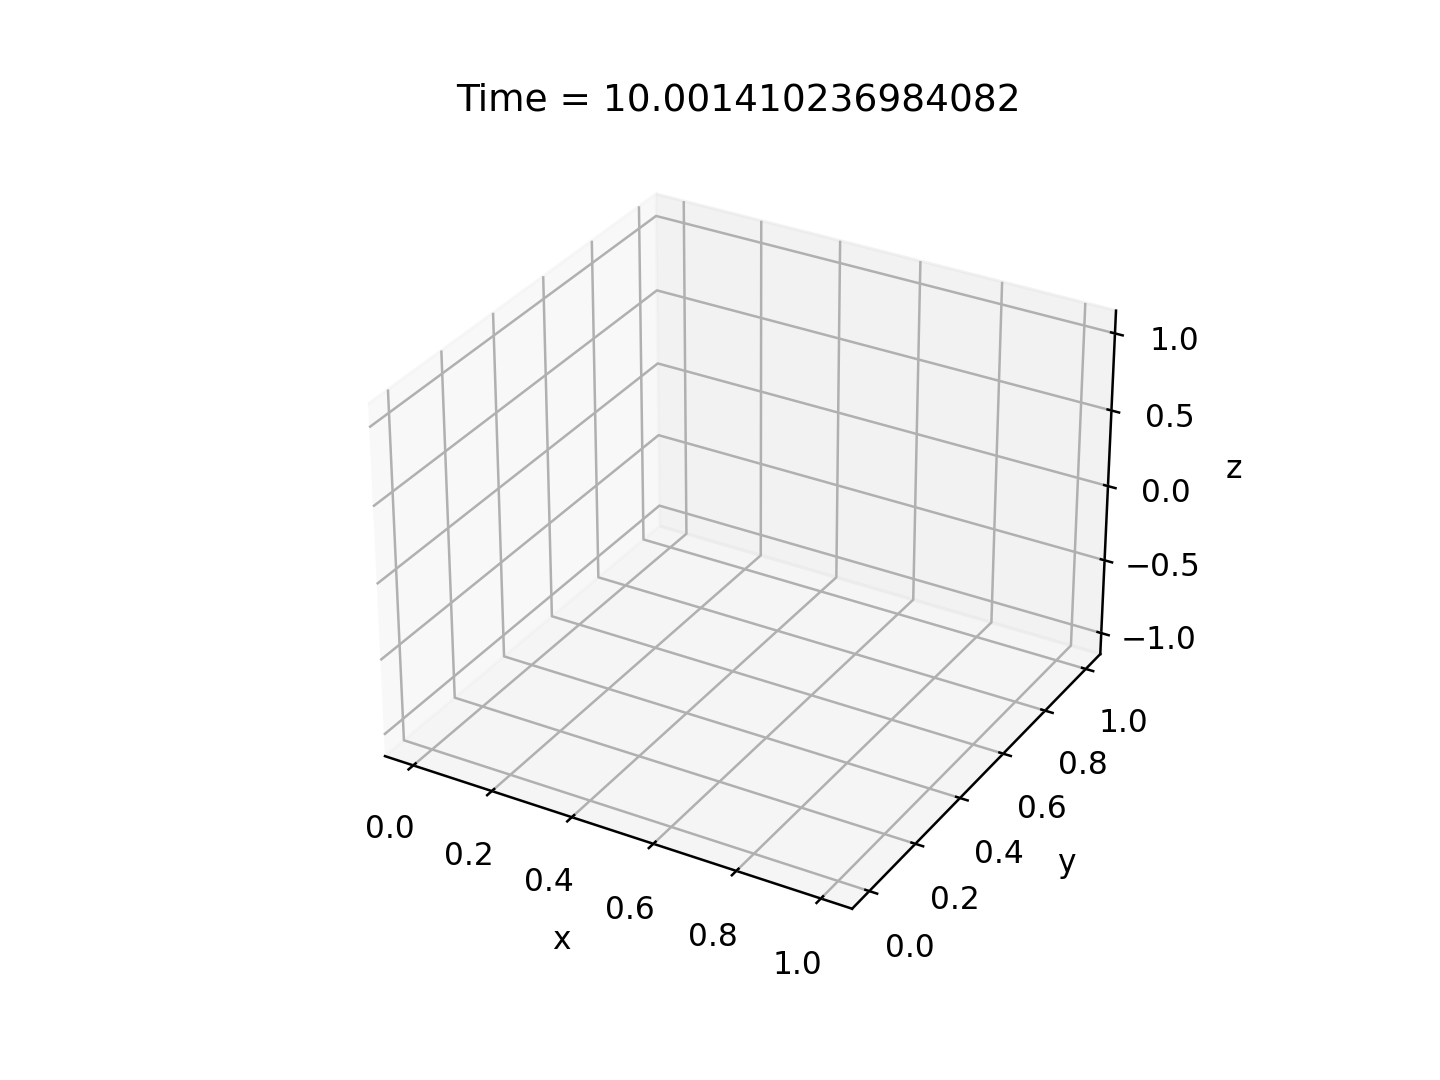

In [15]:
# alpha = 1.001
animate_wave_simulation_3D(U[0], U[3][0])